In [13]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import GPUtil
from collections import defaultdict
from analysis import utils as au
from analysis import plotting
from data import utils as du
from data import se3_diffuser
from data import r3_diffuser
from data import so3_diffuser
from model import loss
from model import reverse_se3_diffusion

import tree
from data import rosetta_data_loader
from data import digs_data_loader
from experiments import train_se3_diffusion
from experiments import inference_se3_diffusion
from openfold.utils import rigid_utils as ru
from data import all_atom
from scipy.spatial.transform import Rotation

from omegaconf import OmegaConf
import importlib

Rigid = ru.Rigid
Rotation = ru.Rotation

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

In [14]:
# Reloads any code changes to 
importlib.reload(rosetta_data_loader)
importlib.reload(digs_data_loader)
importlib.reload(se3_diffuser)
importlib.reload(so3_diffuser)
importlib.reload(r3_diffuser)
importlib.reload(du)
importlib.reload(reverse_se3_diffusion)
importlib.reload(train_se3_diffusion)

<module 'experiments.train_se3_diffusion' from '/data/rsg/chemistry/jyim/projects/protein_diffusion/experiments/train_se3_diffusion.py'>

In [15]:
# Load config.
conf = OmegaConf.load('../config/base.yaml')

# Redirect cache from notebook directory.
exp_conf = conf.experiment
exp_conf.data_location = 'rosetta'
exp_conf.ckpt_dir = None
exp_conf.num_loader_workers = 0
exp_conf.dist_mode = 'single'
exp_conf.use_wandb = False

# Data settings
data_conf = conf.data
data_conf.rosetta.filtering.subset = 1
data_conf.rosetta.filtering.max_len = 80

# Diffusion settings
diff_conf = conf.diffuser
diff_conf.diffuse_trans = True  # whether to diffuse translations
diff_conf.diffuse_rot = True  # whether to diffuse rotations
# Noise schedules
diff_conf.rot_schedule = 'linear'
diff_conf.trans_schedule = 'exponential'

diff_conf.trans_align_t = True

# print(OmegaConf.to_yaml(conf))

In [16]:
# Figure out data loading for PDB on rosetta
exp = train_se3_diffusion.Experiment(conf=conf)
train_loader, valid_loader = exp.create_rosetta_dataset(0, 1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
exp._model = exp._model.to(device)

INFO: Number of model parameters 1464719
INFO: Using cached IGSO3.
INFO: Checkpoint not being saved.
INFO: Evaluation saved to: ./results/baseline/22D_09M_2022Y_06h_58m_27s
INFO: Training: 1 examples
INFO: Validation: 4 examples with lengths [64 64 64 64 64 64 64 64 64 64]


In [17]:
train_iter = iter(train_loader)
next_item = next(train_iter)
# next_item = tree.map_structure(lambda x: x[0], next_item)

In [18]:
next_item.keys()

dict_keys(['aatype', 'res_idx', 'seq_idx', 'res_mask', 'atom37_pos', 'atom37_mask', 'atom14_pos', 'atom14_mask', 'rigidgroups_0', 'rigidgroups_0_exists', 'torsion_angles_sin_cos', 'torsion_angles_mask', 'rel_rots', 'proximity_graph', 'proximity_dists', 'chain_graph', 'chain_dists', 'chain_graph_mask', 'rigids_0', 'rigids_t', 'trans_score', 'rot_score', 't', 'rot_score_norm', 'trans_score_norm'])

In [19]:
next_item['rel_rots'].shape

torch.Size([16, 80, 80, 3])

In [ ]:
rigids = ru.Rigid.from_tensor_7(next_item['rigids_t'])

In [11]:
rot_mats = rigids.get_rots().get_rot_mats()
batch_size, num_res, _, _ = rot_mats.shape

In [12]:
rot_mats_t = rot_mats.transpose(-1, -2)

In [15]:
rot_mats.shape

torch.Size([16, 80, 3, 3])

In [ ]:
rel_rots = torch.einsum('bnmij,bnmjk->bnmik', rot_mats[:, :, None], rot_mats_t[:, None, :])
rel_rots = du.move_to_np(rel_rots)
rel_rots = du.matrix_to_rotvec(rel_rots.reshape(-1, 3, 3)).reshape(batch_size, num_res, num_res, 3)

In [18]:
rel_rots = du.move_to_np(rel_rots)
du.matrix_to_rotvec(rel_rots.reshape(-1, 3)).reshape()

torch.Size([16, 80, 80, 3, 3])

In [110]:
proximity_graph = next_item['proximity_graph']
batch_size, num_res, num_prox_neighbors = proximity_graph.shape

In [122]:
proximity_graph.shape

torch.Size([16, 80, 16])

In [111]:
proximity_graph.reshape(batch_size, -1).shape

torch.Size([16, 1280])

In [113]:
edge_embed_indices = torch.stack(
    [torch.tile(torch.arange(num_res).repeat_interleave(num_prox_neighbors), (batch_size, 1)),
     proximity_graph.reshape(batch_size, -1)],
    dim=-1
)

In [127]:
# x = torch.arange(batch_size*num_res**2*3).reshape(batch_size, num_res, num_res, 3)
x = torch.arange(batch_size*num_res**2*3).reshape(batch_size, num_res, num_res, 3)

In [143]:
proximity_x = torch.gather(x, -2, torch.tile(proximity_graph[..., None], (1, 1, 1, 3)))

In [134]:
x.shape

torch.Size([16, 80, 80, 3])

In [132]:
proximity_graph.shape

torch.Size([16, 80, 16])

In [138]:
x[0, 0, 1]

tensor([3, 4, 5])

In [137]:
proximity_graph[0, 0, 0]

tensor(1)

In [144]:
proximity_x[0, 0, 0]

tensor([3, 4, 5])

In [129]:
dim1 = 2
dim2 = 3
dim3 = 4
source = torch.FloatTensor(dim1, dim2, dim3)
index = source.argmax(dim=0).unsqueeze(0)
source.gather(0, index).squeeze(0)

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.3822e-44, 0.0000e+00, 1.4013e-45, 0.0000e+00]])

In [130]:
source.shape

torch.Size([2, 3, 4])

In [131]:
index.shape

torch.Size([1, 3, 4])

In [120]:
num_res

80

In [121]:
edge_embed_indices[:, :, 0].shape

torch.Size([16, 1280])

In [118]:
x[:, edge_embed_indices[:, :, 0], edge_embed_indices[:, :, 1]].shape

IndexError: index 16 is out of bounds for dimension 0 with size 16

In [92]:
x[edge_embed_indices[:, 0], edge_embed_indices[:, 1]].reshape(num_res, num_prox_neighbors, -1).shape

torch.Size([80, 16, 3])

In [87]:
edge_embed_indices[0].shape

torch.Size([2])

In [51]:
torch.gather(x, 0, edge_embed_indices).shape

RuntimeError: Index tensor must have the same number of dimensions as input tensor

In [49]:
x[edge_embed_indices].shape

torch.Size([1280, 2, 260, 2])

In [34]:
proximity_graph

torch.Size([260, 16])

In [35]:
torch.gather(x, 1, proximity_graph).shape

RuntimeError: Index tensor must have the same number of dimensions as input tensor

In [70]:
# Extract features
rigids_tensor = next_item['rigids_t']
rigids = Rigid.from_tensor_7(rigids_tensor)
res_mask = next_item['res_mask']
res_idx = next_item['res_idx']

atom_pos = all_atom.compute_backbone(
    rigids,
    torch.zeros(res_mask.shape + (2,)).to(res_mask.device)
)[0]

bb_pos = atom_pos[:, :4]
ca_pos = bb_pos[:, 1]
num_res = ca_pos.shape[0]

In [55]:
# Calculate proximity graph
dists_2d = torch.linalg.norm(ca_pos[None, :, :] - ca_pos[:, None, :], axis=-1)
dists_2d += torch.eye(num_res)*1e5
_, topk_graph = torch.topk(dists_2d, k=16, dim=-1, largest=False)

proximity_pos = bb_pos[topk_idx]
proximity_dists = bb_pos[:, :, None, None, :] - proximity_graph[:, None, :, :, :]

In [97]:
# Calculate chain graph
seq_idx = np.arange(num_res) + 1
chain_graph = []
for i in np.arange(-4, 5):
    if i != 0:
        chain_graph.append(
            np.roll(seq_idx, i)
        )
# 1-indexed chain graph
chain_graph = np.stack(chain_graph, axis=-1)
# Chain graph mask for edges
chain_graph_mask = (chain_graph != 0)
# 0-indexed chain graph
chain_graph -= 1

chain_pos = bb_pos[chain_graph]
chain_pos *= chain_graph_mask[..., None, None]
chain_dists = bb_pos[:, :, None, None, :] - chain_pos[:, None, :, :, :]

In [103]:
chain_pos.shape

torch.Size([260, 8, 4, 3])

In [87]:
chain_graph[0]

tensor([0, 0, 0, 0, 2, 3, 4, 5])

In [78]:
res_idx

tensor([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
         29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
         43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
         57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
         71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
         85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
         99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
        113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
        127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
        141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  

In [79]:
chain_graph[-1]

tensor([4, 3, 2, 1, 0, 0, 0, 0])

In [53]:
proximity_edges = bb_pos[:, :, None, None, :] - proximity_graph[:, None, :, :, :]

In [54]:
proximity_edges.shape

torch.Size([260, 4, 16, 4, 3])

## Training

In [26]:
step = 0
epoch = 0
train_losses = defaultdict(list)
log_losses = defaultdict(list)
latest_aux_data = []
sampled_ts = []

In [30]:
num_epochs = 100000
def update_logs(x,y):
    for k in y:
        if 'loss' in k:
            x[k].append(y[k])
log_freq = 100

exp._model = exp._model.to(device)
exp._model.train()
while epoch < num_epochs:
    epoch += 1
    for train_features in train_loader:
        step += 1
        exp.step = step
        exp.num_epochs = epoch
        sampled_ts.append(train_features['t'])
        train_features = tree.map_structure(
            lambda x: x.to(device), train_features)
        _, aux_data = exp.update_fn(train_features)
        aux_data = tree.map_structure(du.move_to_np, aux_data)
        latest_aux_data.append(aux_data)
        update_logs(train_losses, aux_data)
        update_logs(log_losses, aux_data)
        if step == 1 or step % log_freq == 0:
            print_log = f'Step {step}: '
            for k,v in log_losses.items():
                print_log += f'{k}={np.mean(v):.4f} '
            print(print_log)
            log_losses = defaultdict(list)
            latest_aux_data = []

KeyboardInterrupt: 

In [ ]:
f, axes = plt.subplots(1, 4, figsize=[24, 5])

axes[0].plot(train_losses['rot_loss'])
axes[0].set_xlabel('steps')
axes[0].set_ylabel('Rotation loss')

axes[1].plot(train_losses['trans_loss'])
axes[1].set_xlabel('steps')
axes[1].set_ylabel('Translation loss')

axes[2].plot(train_losses['psi_loss'])
axes[2].set_xlabel('steps')
axes[2].set_ylabel('Psi loss')

axes[3].plot(train_losses['total_loss'])
axes[3].set_xlabel('steps')
axes[3].set_ylabel('Total loss')

In [ ]:
ckpt_path = './dev_models/test.pkl'
du.write_checkpoint(
    ckpt_path, exp.model.state_dict(), exp._conf)

## Data visualization

In [ ]:
# Figure out data loading for PDB on rosetta
exp = train_se3_diffusion.Experiment(conf=conf)
train_loader, valid_loader = exp.create_rosetta_dataset(0, 1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
exp._model = exp._model.to(device)

In [10]:
train_iter = iter(train_loader)
next_item = next(train_iter)
print(next_item['t'])

tensor([0.1632, 0.9439, 0.0210, 0.8138, 0.7958, 0.5495, 0.3113, 0.5355, 0.4074,
        0.6256, 0.8358, 0.2933, 0.4635, 0.0430, 0.5556, 0.2392],
       dtype=torch.float64)


In [40]:
torch.sum(next_item['res_mask'][0])

tensor(207., dtype=torch.float64)

In [37]:
# Visualize example
b_idx = -4
rigids_t, noisy_se3_vec = process_rigids(next_item['rigids_t'], b_idx)
rigids_0, gt_se3_vec = process_rigids(next_item['rigids_0'], b_idx)

ax_lim = 15
f, axes = plt.subplots(1, 2, figsize=[16, 8], subplot_kw=dict(projection="3d"))
plotting.plot_se3(gt_se3_vec, ax=axes[0], title='Initialization', ax_lim=ax_lim)
plotting.plot_se3(noisy_se3_vec, ax=axes[1], title='Sampled frame', ax_lim=ax_lim)

NameError: name 'process_rigids' is not defined

## Sampling

In [184]:
# Sample data point to initializez.
data_iter = iter(train_loader)
raw_data_feats = next(data_iter)

In [185]:
# Preprocess init data
exp_diffuser = exp.diffuser
batch_idx = 2
data_feats = tree.map_structure(lambda x: x[batch_idx], raw_data_feats)
res_mask = data_feats['res_mask']
res_idx = data_feats['res_idx']
rigids_0 = data_feats['rigids_0']

rigids_0 = rigids_0[torch.where(res_mask.bool())]
res_mask = res_mask[torch.where(res_mask.bool())]


In [186]:

num_res = res_mask.shape[0]
rigids_init = exp_diffuser.sample_ref(
    num_res,
#     impute=ru.Rigid.from_tensor_7(rigids_0)
).to_tensor_7()
rigids_init *= res_mask[:, None]
init_feats = {
    'rigids_t': rigids_init,
    'res_mask': res_mask,
    'res_idx': res_idx,
#     'res_idx': res_idx[torch.where(res_mask.bool())],
    't': torch.tensor(1.0),
    'rot_score_norm': data_feats['rot_score_norm'],
    'trans_score_norm': data_feats['trans_score_norm'],
}

num_res = res_mask.shape[0]
init_feats = tree.map_structure(lambda x: x[None].to(device), init_feats)
print(f'Sample length {torch.sum(res_mask)}')

Sample length 125.0


In [188]:
# Run inference
infer_out = exp.inference_fn(init_feats, add_noise=True)
sample_rigids = infer_out[0]

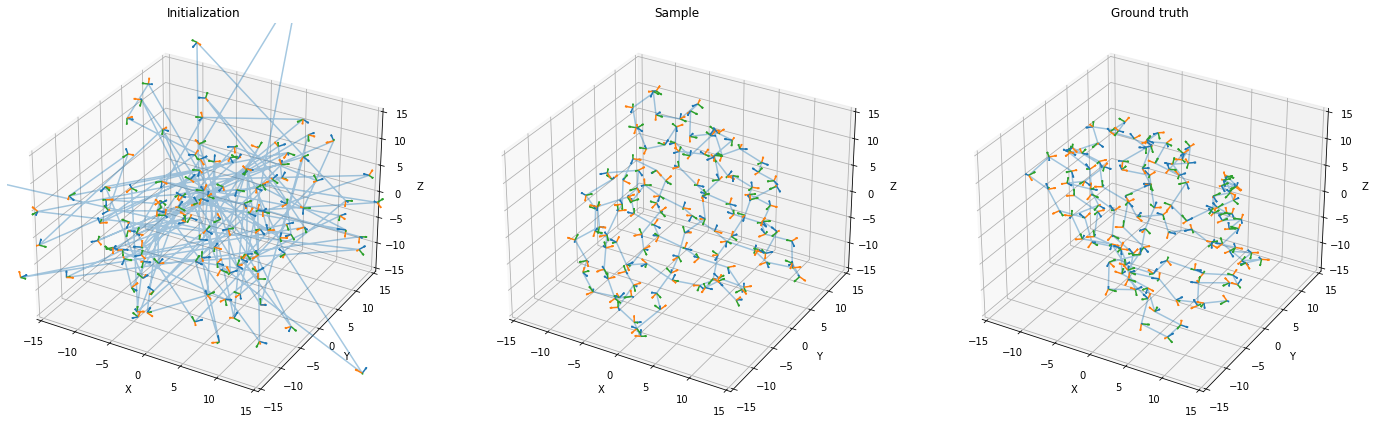

In [189]:
# Plot out SE(3)
final_rigid = sample_rigids[-1][0]
f, axes = plt.subplots(1, 3, figsize=[24, 8], subplot_kw=dict(projection="3d"))
scale_factor = conf.data.digs.scale_factor
ax_lim = 15.
plotting.viz_frames(init_feats['rigids_t'][0], res_mask, axes[0], title='Initialization', scale_factor=scale_factor, ax_lim=ax_lim)
plotting.viz_frames(final_rigid, res_mask, axes[1], title='Sample', scale_factor=scale_factor, ax_lim=ax_lim)
plotting.viz_frames(rigids_0, res_mask, axes[2], title='Ground truth', scale_factor=scale_factor, ax_lim=ax_lim)

In [190]:
# Calculate FAPE and Ca-RMSD metrics.
fape_loss = loss.rigids_fape(
    final_rigid,
    rigids_0.to(device),
    res_mask.to(device),
    length_scale=scale_factor)
rmsd_loss, aligned_pred_ca, gt_ca, align_rot_mat, align_trans, reflection = loss.rigids_ca_rmsd(
    final_rigid,
    rigids_0.to(device),
    res_mask.to(device),
    length_scale=scale_factor,
    return_align=True)
align_rot_euler = Rotation.from_matrix(align_rot_mat).as_euler('xyz', degrees=True)
print(f'FAPE: {fape_loss:2.4f}\nCa-RMSD: {rmsd_loss:2.4f}')
print(f'Alignment rotation: {align_rot_euler}\nAlignment translation: {align_trans[:,0]}\nAlignment reflection: {reflection}')


FAPE: 0.0319
Ca-RMSD: 1.4931
Alignment rotation: [-158.46177987   66.47578861  -47.74467577]
Alignment translation: [ 6.641922e-08 -5.957877e-08  3.364813e-08]
Alignment reflection: False


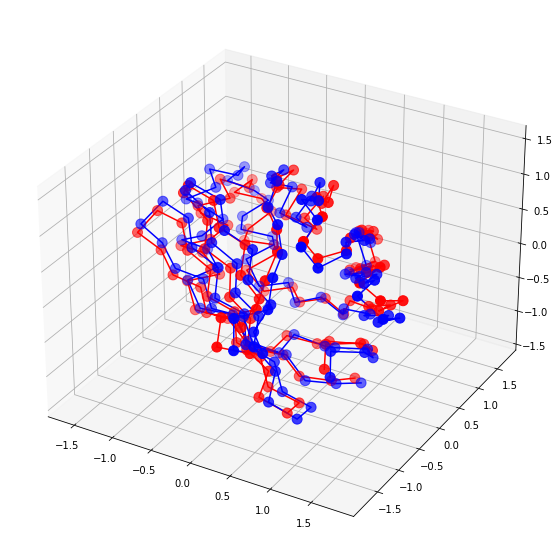

In [191]:
# Visualize aligned Ca structures
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

plotting.plt_3d(aligned_pred_ca, ax, color='r', s=100, mode='scatter')
plotting.plt_3d(aligned_pred_ca, ax, color='r', mode='line')
plotting.plt_3d(gt_ca, ax, color='b', s=100, mode='scatter')
plotting.plt_3d(gt_ca, ax, color='b', mode='line')